In [ ]:
import pandas as pd
import numpy as np
import pylab 
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('seaborn')
%matplotlib inline
import seaborn as sns
import missingno as msno
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

#Import the library, authenticate, and create the interface to csv files.
# !pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
###Read file from drive 
link="https://drive.google.com/open?id=1GmYd_wKvBzBbZHkx0FbYfNM585nfgTj9"
_,id=link.split("=")
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('myfile.csv')  
df = pd.read_csv('myfile.csv')

df['BUILDING CLASS CATEGORY']=df['BUILDING CLASS CATEGORY'].str.strip()
df['APARTMENT NUMBER']=df['APARTMENT NUMBER'].str.strip()
df['APARTMENT NUMBER']=df['APARTMENT NUMBER'].fillna('')
df['NEIGHBORHOOD']=df['NEIGHBORHOOD'].str.strip()
df=df.astype({'BLOCK':'str','LOT':'str','SALE DATE':'datetime64','SALE PRICE':'float'})
df['year']=df['SALE DATE'].dt.year
df['month']=df['SALE DATE'].dt.month
df['ym']=df.astype({'year':'str'})['year']+df.astype({'month':'str'})['month'].str.zfill(2)
df['ADDRESS']=df['ADDRESS'].str.replace('.','',regex=False)

### Apartment Number Adjustment
pro=df[['BLOCK','LOT','ADDRESS','APARTMENT NUMBER']]
x=pro.ADDRESS.str.split(', |APT ',expand=True)
pro['ads']=x[0]
pro['apt']=x[2].str.strip().fillna(x[1].str.strip())
pro['APARTMENT NUMBER'].loc[pro['APARTMENT NUMBER']=='']=pro.loc[pro['APARTMENT NUMBER']=='']['apt']
# pro[(pro['BLOCK']=='100')&(pro['LOT']=='1003')]
df['ADDRESS']=pro['ads']
df['APARTMENT NUMBER']=pro['APARTMENT NUMBER']
df=df[df['APARTMENT NUMBER']!='']
df=df[(df['ZIP CODE']!=10463)&(df['ZIP CODE']>0)]

df=df[['BLOCK', 'LOT',  'ADDRESS', 'APARTMENT NUMBER','ZIP CODE',
       'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',  'YEAR BUILT', 'SALE DATE', 
       'SALE PRICE', 
       'year', 'month', 'ym', 'logprice',
       'TAX CLASS AT PRESENT', 'BUILDING CLASS AT PRESENT']]
df=df.rename(columns={'APARTMENT NUMBER':'APT', 'ZIP CODE':'ZIP',
       'NEIGHBORHOOD':'NBHD', 'BUILDING CLASS CATEGORY':'CATEGORY', 'YEAR BUILT':'YBUILT', 'SALE DATE':'DATE',
       'SALE PRICE':'PRICE', 
       'TAX CLASS AT PRESENT':'TAXCLASS','BUILDING CLASS AT PRESENT':'BDCLASS'})

In [ ]:
df.head(2)

,BLOCK,LOT,ADDRESS,APT,ZIP,NBHD,CATEGORY,YBUILT,DATE,PRICE,year,month,ym,logprice,TAXCLASS,BDCLASS
0,373,46,317 EAST 3RD ST,5,10009,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,1925.0,2003-11-14,190000.0,2003,11,200311,12.154779,2,C6
1,373,46,317 EAST 3 ST,21,10009,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,1925.0,2003-12-05,270000.0,2003,12,200312,12.506177,2,C6


In [ ]:
###Check Category information
print(df.shape)
print(df.groupby('CATEGORY')['PRICE'].count())
print(df.groupby('CATEGORY')['PRICE'].count()/df.shape[0]*100)
a=df.groupby(['BLOCK','LOT','APT'])['PRICE'].count().to_frame().reset_index()
print(len(a[a['PRICE']>1]),len(a),np.round(len(a[a['PRICE']>1])/len(a)*100,2),'%')

(227606, 16)
CATEGORY
09 COOPS - WALKUP APARTMENTS        12519
10 COOPS - ELEVATOR APARTMENTS     104591
12 CONDOS - WALKUP APARTMENTS        1567
13 CONDOS - ELEVATOR APARTMENTS    108929
Name: PRICE, dtype: int64
CATEGORY
09 COOPS - WALKUP APARTMENTS        5.500294
10 COOPS - ELEVATOR APARTMENTS     45.952655
12 CONDOS - WALKUP APARTMENTS       0.688470
13 CONDOS - ELEVATOR APARTMENTS    47.858580
Name: PRICE, dtype: float64
50405 147381 34.2 %


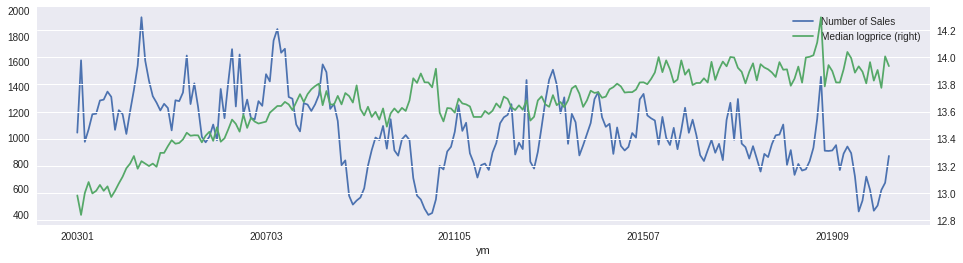

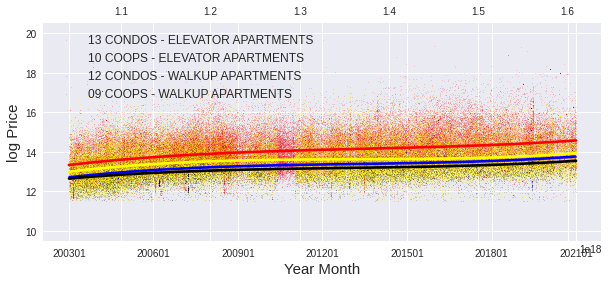

In [ ]:
###Yearmonth/category vs Sales Charts
ax=df.groupby(['ym'])['logprice'].count().to_frame().reset_index().plot(x='ym',y='logprice',label='Number of Sales',figsize=(24,4))
df.groupby(['ym'])['logprice'].describe()['50%'].to_frame().reset_index().plot(x='ym',y='50%',figsize=(16,4),label='Median logprice',ax=ax,secondary_y=True)
plt.show()

cat=['13 CONDOS - ELEVATOR APARTMENTS','10 COOPS - ELEVATOR APARTMENTS','12 CONDOS - WALKUP APARTMENTS','09 COOPS - WALKUP APARTMENTS']
plt.figure(figsize=(10,4))
sns.scatterplot(x=['200301','200601','200901','201201','201501','201801','202101'],y=np.linspace(10,20,7),s=0.1)
plt.xlabel('Year Month', fontsize=15)
plt.ylabel('log Price', fontsize=15)
ax2 = plt.twiny()
sns.regplot(x=np.asarray(df[df['CATEGORY']==cat[0]]['DATE']).astype(float),y=df[df['CATEGORY']==cat[0]]['logprice'],scatter_kws={'s':0.15, 'alpha':0.7},order=3,ci=None,label=cat[0],ax=ax2,color='red')
sns.regplot(x=np.asarray(df[df['CATEGORY']==cat[1]]['DATE']).astype(float),y=df[df['CATEGORY']==cat[1]]['logprice'],scatter_kws={'s':0.15, 'alpha':0.7},order=3,ci=None,label=cat[1],ax=ax2,color='yellow')
sns.regplot(x=np.asarray(df[df['CATEGORY']==cat[2]]['DATE']).astype(float),y=df[df['CATEGORY']==cat[2]]['logprice'],scatter_kws={'s':0.15, 'alpha':0.7},order=3,ci=None,label=cat[2],ax=ax2,color='blue')
sns.regplot(x=np.asarray(df[df['CATEGORY']==cat[3]]['DATE']).astype(float),y=df[df['CATEGORY']==cat[3]]['logprice'],scatter_kws={'s':0.15, 'alpha':0.7},order=3,ci=None,label=cat[3],ax=ax2,color='black')
plt.legend(fontsize='large',loc='upper left')
plt.show()

In [ ]:
###Filter greater than 1
df1 = df[df.groupby(['BLOCK','LOT', 'APT'])['PRICE'].transform('count') > 1]
# df1=df1[(df1['APT']!='')]
result=df1.groupby(['BLOCK','LOT','APT','DATE'])['PRICE'].max().to_frame().reset_index()

###Add number of trades happened
trades=df.groupby(['BLOCK','LOT','APT'])['PRICE'].count().to_frame().reset_index().rename(columns={'PRICE':'trade'})

###shift price 1 2 3 & days
result=result.assign(Days= lambda x: (x["DATE"]-pd.Timestamp('2003-01-02')).dt.days)

###Price Shift
lag_list = [1]
for lag in lag_list:
    result[('PRICE_SHIFT%s' % lag)] = result.sort_values('Days').groupby(['BLOCK', 'LOT',"APT"])['PRICE'].shift(lag)
    result[('PRICE_SHIFT%s' % lag)].fillna(0, inplace=True)

###Days Shift
lag_list = [1]
for lag in lag_list:
    result[('DATE_SHIFT%s' % lag)] = result.sort_values('Days').groupby(['BLOCK', 'LOT', "APT"])['DATE'].shift(lag)
    result[('DATE_SHIFT%s' % lag)].fillna(0, inplace=True)

combined = pd.merge(result,df[['BLOCK', 'LOT', 'ZIP', 'APT',"DATE","NBHD","CATEGORY","YBUILT"]], on = ['BLOCK', 'LOT', 'APT',"DATE"])
combined = pd.merge(combined,trades, on = ['BLOCK', 'LOT', 'APT'])
combined.head(2)

,BLOCK,LOT,APT,DATE,PRICE,Days,PRICE_SHIFT1,DATE_SHIFT1,ZIP,NBHD,CATEGORY,YBUILT,trade
0,100,1003,2A,2003-09-15,999922.0,256,0.0,0,10038,SOUTHBRIDGE,13 CONDOS - ELEVATOR APARTMENTS,0.0,2
1,100,1003,2A,2007-05-04,1665000.0,1583,999922.0,2003-09-15 00:00:00,10038,SOUTHBRIDGE,13 CONDOS - ELEVATOR APARTMENTS,0.0,2


In [ ]:
### Model with only shift1 with not zero
data = combined[combined["PRICE_SHIFT1"]!=0]
data = data[data["YBUILT"]!=0]
data.dropna(inplace=True)
data['PRICE_RETURN']=np.log(data['PRICE']/data['PRICE_SHIFT1'])*365/data['Days']
#data.YBUILT=data.YBUILT
#data.Days=data.Days
data['year']=data['DATE'].dt.year
data['month']=data['DATE'].dt.month
data['ym']=data.astype({'year':'str'})['year']#+data.astype({'month':'str'})['month'].str.zfill(2)
data['newold']=np.where(data['YBUILT']<=1945,'PREWAR',np.where(data['YBUILT']<1994,'BOOM','NEW'))
data['million']=np.where(data['PRICE']>1000000,'1','0')

data=data.astype({"DATE_SHIFT1":"datetime64"})
data=data.astype({"million":"int"})
data['years']=data['DATE_SHIFT1'].dt.year
data['months']=data['DATE_SHIFT1'].dt.month
data['ym_shift']=data.astype({'years':'str'})['years']#+data.astype({'months':'str'})['months'].str.zfill(2)

data = data[['PRICE_RETURN',"PRICE",'Days','CATEGORY','PRICE_SHIFT1','NBHD',"YBUILT","ym",'ym_shift','newold','million','trade']]
data.head(2)

,PRICE_RETURN,PRICE,Days,CATEGORY,PRICE_SHIFT1,NBHD,YBUILT,ym,ym_shift,newold,million,trade
4,0.018796,2100000.0,4218,13 CONDOS - ELEVATOR APARTMENTS,1690000.0,SOUTHBRIDGE,1900.0,2014,2007,PREWAR,1,4
5,-0.001468,2050000.0,5992,13 CONDOS - ELEVATOR APARTMENTS,2100000.0,SOUTHBRIDGE,1900.0,2019,2014,PREWAR,1,4


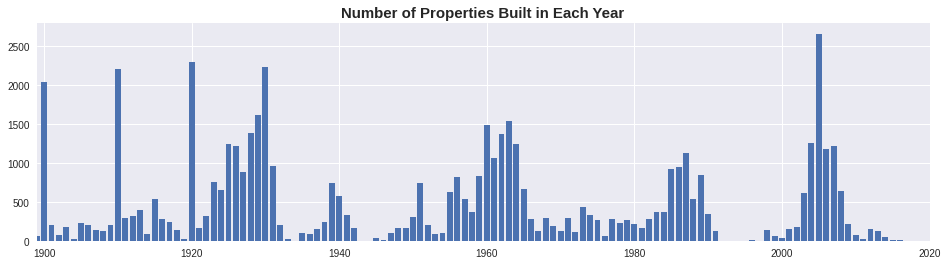

,YBUILT,Counts
58,1934.0,1
114,1994.0,3
68,1946.0,9
115,1996.0,11


In [ ]:
###Number of Properties Built in Each Year Plot
a=data.groupby('YBUILT')['PRICE'].count().to_frame().reset_index().rename(columns={'PRICE':'Counts'})
plt.figure(figsize=(16,4))
plt.bar(a.YBUILT,a.Counts)
plt.xlim([1899,2020])
plt.title('Number of Properties Built in Each Year',fontsize=15, fontweight='bold')
plt.show()
a[(a['YBUILT']>1925)&(a['YBUILT']<2000)].sort_values(by='Counts').head(4)

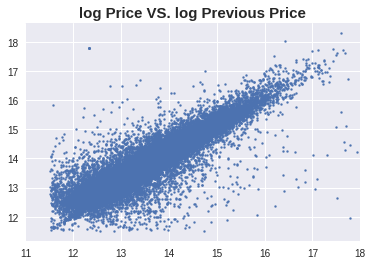

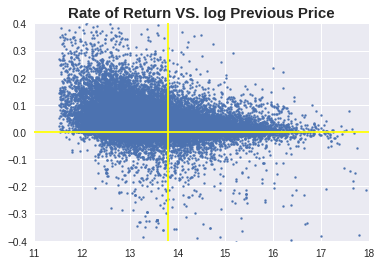

In [ ]:
###Rate return vs log previous price 
plt.scatter(np.log(data.PRICE_SHIFT1),np.log(data.PRICE),s=4)
plt.title('log Price VS. log Previous Price', fontsize=15, fontweight='bold')
plt.xlim([11,18])
plt.show()

plt.scatter(np.log(data.PRICE_SHIFT1),data.PRICE_RETURN,s=4)
plt.plot([11,18],[0,0],color='yellow')
plt.plot([13.81,13.81],[-0.4,0.4],color='yellow')
plt.title('Rate of Return VS. log Previous Price', fontsize=15, fontweight='bold')
plt.xlim([11,18])
plt.ylim([-0.4,0.4])
plt.show()

**Modeling**

In [ ]:
###OlS model
olsmodel="PRICE_RETURN~np.log(PRICE_SHIFT1)*NBHD*newold*million*trade+ym_shift*ym" #
# olsmodel="PRICE_RETURN~np.log(PRICE_SHIFT1)*NBHD+YBUILT+ym_shift*ym"
m1=ols(olsmodel,data).fit()
print('np.log(PRICE_SHIFT1)\t','newold[T.NEW]\t    ','newold[T.PREWAR]\t','million\t','trade')
print(m1.params['np.log(PRICE_SHIFT1)'],m1.params['newold[T.NEW]'],m1.params['newold[T.PREWAR]'],m1.params['million'],m1.params['trade'])
print('  ',m1.pvalues['np.log(PRICE_SHIFT1)'],m1.pvalues['newold[T.NEW]'],m1.pvalues['newold[T.PREWAR]'],m1.pvalues['million'],m1.pvalues['trade'])
print(m1.rsquared)
# m1.summary()

np.log(PRICE_SHIFT1)	 newold[T.NEW]	     newold[T.PREWAR]	 million	 trade
-0.0062291763826126416 -0.5189352477552391 0.329806000023033 2.7580856395056217 0.21544892669112845
   0.9843655432849032 0.9093147614505275 0.938215024647197 0.7929572442121265 0.9150628089872934
0.49593159446048474


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import plotly.offline as py
import scipy.stats as spst
import scipy.special as spsp
from statsmodels.formula.api import ols, logit,mnlogit,poisson,negativebinomial
from statsmodels.base.model import GenericLikelihoodModel

In [ ]:
###Data processing for prediction model
datar=data[['PRICE_RETURN','CATEGORY','PRICE_SHIFT1','NBHD','YBUILT','ym','ym_shift','newold','million','trade']]
datar=pd.get_dummies(datar,columns=["CATEGORY","NBHD","ym","ym_shift","newold"])
datar["PRICE_SHIFT1"]=np.log(datar["PRICE_SHIFT1"])
aa = int(datar.shape[0]*0.8)
train=datar.iloc[0:aa,:]
test=datar.iloc[aa:-1,:]
train.shape[0],test.shape[0]
Trainingx=train.iloc[:,1:-1]
Trainingy=train.iloc[:,0]
Testingx=test.iloc[:,1:-1]
Testingy=test.iloc[:,0]

# print model accuracy function
def model_result(model, X_train,y_train,X_test, y_test):
    print("--------- Testing Accuracy ----------")
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print("Testing R_square:",r2_score(y_test, y_pred))
    print('Testing Mean Squared Error:',mse(y_test, y_pred))
    print("--------- Training Accuracy ----------")
    y_train_pred = model.predict(X_train)
    print("Training R_square:",r2_score(y_train, y_train_pred))
    print('Training Mean Squared Error:',mse(y_train, y_train_pred))
    return y_pred

In [ ]:
### Linear Regression Model
#lr_scaler = MinMaxScaler()
#lr_scaler.fit(Trainingx)
#lr_train = lr_scaler.transform(Trainingx)
#lr_test = lr_scaler.transform(Testingx)
#lr_train = Trainingx
#lr_test = Testingx
#lr_model = LinearRegression()
#y_pred_lr = model_result(lr_model, lr_train, Trainingy, lr_test, Testingy)

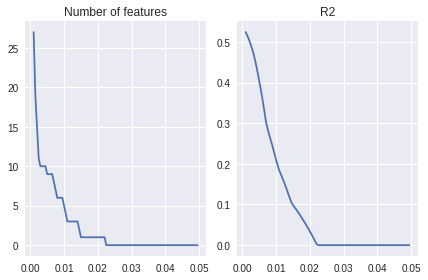

best alpha 0.001
corresponding R2 0.5242144510235344


In [ ]:
##Lasso Regression 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
modelX=StandardScaler().fit(Trainingx)
TrainingXsd=pd.DataFrame(modelX.transform(Trainingx))
TestingXsd=pd.DataFrame(modelX.transform(Testingx))

def Routofsample(Prediction, Actual):
  R2=1-np.sum((Prediction-Actual)**2)/np.sum((Actual-np.mean(Actual))**2)
  return R2
def Lasso_function(a):
  model=Lasso(alpha=a, fit_intercept=False)
  model.fit(TrainingXsd,Trainingy-np.mean(Trainingy))
  Prediction=model.predict(TestingXsd)+np.mean(Trainingy)
  return  np.sum(~(model.coef_==0)), Routofsample(Prediction, Testingy)
  
alpha_array= np.arange(0.001,0.05,0.0005)
returns=np.array([Lasso_function(alpha) for alpha in alpha_array])
Number_Variables=returns[:,0]
R2=returns[:,1]
ax=plt.figure()
ax.add_subplot(121)
plt.title("Number of features")
plt.plot(alpha_array,Number_Variables)
ax.add_subplot(122)
plt.title("R2")
plt.plot(alpha_array,R2)
ax.tight_layout()
plt.show()

best_alpha=alpha_array[np.argmax(R2)]
print("best alpha", best_alpha)
print("corresponding R2",np.max(R2))

In [ ]:
###Reweighted coeff with optiml alpha
def Lasso_function(best_alpha):
  model=Lasso(alpha=best_alpha, fit_intercept=False)
  model.fit(TrainingXsd,Trainingy-np.mean(Trainingy))
  Prediction=model.predict(TestingXsd)+np.mean(Trainingy)
  return model.coef_
Reweighted_coefficient=Lasso_function(best_alpha)/Trainingx.std()
Reweighted_coefficient=Reweighted_coefficient[Reweighted_coefficient!=0]
print(len(Reweighted_coefficient))
Reweighted_coefficient

34


PRICE_SHIFT1                               -0.031872
million                                     0.044452
trade                                      -0.000576
CATEGORY_09 COOPS - WALKUP APARTMENTS      -0.001300
CATEGORY_13 CONDOS - ELEVATOR APARTMENTS    0.003317
NBHD_CHELSEA                                     NaN
NBHD_FASHION                                     NaN
NBHD_FLATIRON                                    NaN
NBHD_GRAMERCY                                    NaN
NBHD_INWOOD                                -0.001265
NBHD_JAVITS CENTER                               NaN
NBHD_KIPS BAY                                    NaN
NBHD_LITTLE ITALY                           0.011388
NBHD_MIDTOWN CBD                            0.004600
NBHD_MIDTOWN EAST                          -0.000399
NBHD_MURRAY HILL                                 NaN
NBHD_SOHO                                   0.001384
NBHD_UPPER WEST SIDE (59-79)                0.001428
NBHD_WASHINGTON HEIGHTS LOWER              -0.

In [ ]:
###Random Forest
rf_model = RandomForestRegressor(n_estimators=50, max_depth=18, random_state=0, n_jobs=-1)
rf_test_pred = model_result(rf_model,Trainingx, Trainingy, Testingx, Testingy)

--------- Testing Accuracy ----------
Testing R_square: 0.5576785356170069
Testing Mean Squared Error: 0.0010620839015974002
--------- Training Accuracy ----------
Training R_square: 0.869328130618104
Training Mean Squared Error: 0.0005697458456448682


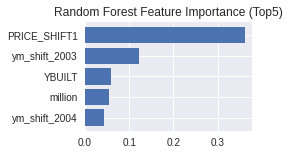

In [ ]:
# generate importance of features
selected_feature = Trainingx.columns.tolist()
importance = rf_model.fit(Trainingx, Trainingy).feature_importances_
feature_score = list(zip(list(selected_feature), importance))
feature_score.sort(key = lambda x: x[1], reverse=True)
fs = pd.DataFrame(importance, index=selected_feature, columns=['Importance'])
fs.sort_values(by=['Importance'], inplace=True)
plt.figure(figsize=(3, 2))
plt.barh(fs[-5:].index, fs['Importance'][-5:])
plt.title('Random Forest Feature Importance (Top5)')
plt.rcParams["font.size"] = "14"
plt.show()

In [ ]:
###XGBOOST
xgb_model = XGBRegressor()
xgb_test_pred = model_result(xgb_model, Trainingx, Trainingy, Testingx, Testingy)

--------- Testing Accuracy ----------
[03:30:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Testing R_square: 0.6149221824868258
Testing Mean Squared Error: 0.000924632837824202
--------- Training Accuracy ----------
Training R_square: 0.6309529409105716
Training Mean Squared Error: 0.001609091763653831


In [ ]:
### generate importance of features
# importance = xgb_model.fit(Trainingx, Trainingy).feature_importances_
# feature_score = list(zip(list(selected_feature), importance))
# feature_score.sort(key = lambda x: x[1], reverse=True)
# fs = pd.DataFrame(importance, index=selected_feature, columns=['Importance'])
# fs.sort_values(by=['Importance'], inplace=True)
# plt.figure(figsize=(3, 2))
# plt.barh(fs[-5:].index, fs['Importance'][-5:])
# plt.rcParams["font.size"] = "14"
# plt.title("XGBoost Feature Importance (Top 5)")
# plt.show()

**Choice Modeling**

In [ ]:
###Label Sold with 0/1
df1 = df[df.groupby(['BLOCK','LOT','ZIP','APT'])['PRICE'].transform('count') > 1]
df1=df1[(df1['APT']!='')]
df1["Sold"]=1
df2 = df[df.groupby(['BLOCK','LOT','ZIP','APT'])['PRICE'].transform('count') == 1]
df2=df2[(df2['APT']!='')]
df2["Sold"]=0
res = df1.append(df2, ignore_index=True, sort=False)
# Month Shift
res1=res.groupby(['BLOCK','LOT','ZIP','APT','DATE'])['PRICE','year','month','logprice','Sold'].max().reset_index()
Yearstamp=2021
Monthstamp=12
res1=res1.assign(Total_Month=lambda x: (Yearstamp-x['year'])*12 + (Monthstamp-x['month']+1))
res1['Total_Month_shift1'] = res1.sort_values('year').groupby(['BLOCK', 'LOT', 'APT', 'ZIP'])['Total_Month'].shift(1)
# Year Shift
res1=res1.assign(Total_Year=lambda x: Yearstamp-x['year']+1)
res1['Total_Year_shift1'] = res1.sort_values('year').groupby(['BLOCK', 'LOT', 'APT', 'ZIP'])['Total_Year'].shift(1)

###Calculating holding month/year
res1['Holding_Month']=res1.apply(lambda x: x['Total_Month'] if x['Sold']==0 else x['Total_Month_shift1']-x['Total_Month'],axis=1)
res1['Holding_Year']=res1.apply(lambda x: x['Total_Year'] if x['Sold']==0 else x['Total_Year_shift1']-x['Total_Year']+1,axis=1)
res1=res1[(res1['Holding_Month']>0)&(res1['Holding_Year']>0)]
res1.head(2)

,BLOCK,LOT,ZIP,APT,DATE,PRICE,year,month,logprice,Sold,Total_Month,Total_Month_shift1,Total_Year,Total_Year_shift1,Holding_Month,Holding_Year
1,100,1003,10038,2A,2007-05-04,1665000.0,2007,5,14.325336,1,176,220.0,15,19.0,44.0,5.0
2,100,1004,10038,2B,2003-07-17,1725934.0,2003,7,14.361279,0,222,NaN,19,NaN,222.0,19.0


In [ ]:
### Federal interest rate and real interest rate incoroperated
# Fed Rate starts from 2003
FED=[1.13,1.35,3.22,4.97,5.02,1.92,0.16,0.18,0.1,0.14,0.11,0.09,0.13,0.39,1,1.79,2.16,0.36]
year=list(range(2003,2021))
FED_RATE=list(zip(year,FED))
FED_RATE =pd.DataFrame(FED_RATE,columns=['year','Fed_rate'])
# Real Interest Rate starts from 2003
Real=[2.22,1.6,2.98,4.79,5.22,3.08,2.47,2.06,1.14,1.31,1.47,1.37,2.29,2.44,2.18,2.44,3.44,2.30]
REAL_RATE=list(zip(year,Real))
REAL_RATE =pd.DataFrame(REAL_RATE,columns=['year','Real_rate'])
res1=pd.merge(res1,FED_RATE,on='year',how='left')
res1=pd.merge(res1,REAL_RATE,on='year',how='left')
res1.head(3)

,BLOCK,LOT,ZIP,APT,DATE,PRICE,year,month,logprice,Sold,Total_Month,Total_Month_shift1,Total_Year,Total_Year_shift1,Holding_Month,Holding_Year,Fed_rate,Real_rate
0,100,1003,10038,2A,2007-05-04,1665000.0,2007,5,14.325336,1,176,220.0,15,19.0,44.0,5.0,5.02,5.22
1,100,1004,10038,2B,2003-07-17,1725934.0,2003,7,14.361279,0,222,NaN,19,NaN,222.0,19.0,1.13,2.22
2,100,1005,10038,2C,2007-07-20,1690000.0,2007,7,14.340239,1,174,224.0,15,19.0,50.0,5.0,5.02,5.22


In [ ]:
first=pd.Timestamp('2003-01-02')
result=result.assign(Days= lambda x: (x["DATE"]-first).dt.days)
###Price Shift
result['PRICE_SHIFT-1'] = result.sort_values('Days').groupby(['BLOCK', 'LOT',"APT"])['PRICE'].shift(-1)
result['PRICE_SHIFT-1'].fillna(0, inplace=True)
###Day Shift
result['DAY_SHIFT-1'] = result.sort_values('Days').groupby(['BLOCK', 'LOT',"APT"])['Days'].shift(-1)
result['DAY_SHIFT-1'].fillna(0, inplace=True)
###Date Shift
result['DATE_SHIFT-1'] = result.sort_values('Days').groupby(['BLOCK', 'LOT',"APT"])['DATE'].shift(-1)
result['DATE_SHIFT-1'].fillna(0, inplace=True)
###Left Join
combined = pd.merge(result,df[['BLOCK', 'LOT', 'ZIP', 'APT',"DATE","NBHD","CATEGORY","YBUILT"]], on = ['BLOCK', 'LOT', 'APT',"DATE"])
combined = pd.merge(combined,trades, on = ['BLOCK', 'LOT', 'APT'])

data2 = combined[combined["PRICE_SHIFT-1"]!=0]
data2['PRICE_RETURN']=np.log(data2['PRICE_SHIFT-1']/data2['PRICE'])*365/data2['DAY_SHIFT-1']
data2['buy_year']=data2['DATE'].dt.year
data2=data2.astype({"DATE_SHIFT-1":"datetime64"})
data2['sell_year']=data2['DATE_SHIFT-1'].dt.year
res2=data2.rename(columns={'DATE':'BUY_DATE','DATE_SHIFT-1':'SELL_DATE','PRICE':'BUY_PRICE','PRICE_SHIFT-1':'SELL_PRICE','DAY_SHIFT-1':'HOLDING_DAYS','PRICE_RETURN':'GAIN'})
res2=pd.merge(res2,FED_RATE,left_on='buy_year',right_on='year',how='left')
res2=pd.merge(res2,REAL_RATE,left_on='buy_year',right_on='year',how='left')
res2['Holding_year']=res2['SELL_DATE'].dt.to_period('Y').astype(int) - res2['BUY_DATE'].dt.to_period('Y').astype(int)
Real1=[1+i/100 for i in Real]
res2=res2.astype({"buy_year":"int","Holding_year":"int"})
res2['acc_return']=res2.apply(lambda x: np.prod(Real1[(x['buy_year']-2003):(x['buy_year']-2003+x['Holding_year'])])-1,axis=1)

In [ ]:
### buy appartment or deposit money label (Binary Choice)
res2['buy']=res2.apply(lambda x: 1 if x['GAIN']>x['acc_return'] else 0,axis=1)
res2 = res2[res2["YBUILT"]!=0]
res2['newold']=np.where(res2['YBUILT']<=1945,'PREWAR',np.where(res2['YBUILT']<1994,'BOOM','NEW'))
res2['Holding_month']=res2['SELL_DATE'].dt.to_period('M').astype(int) - res2['BUY_DATE'].dt.to_period('M').astype(int)
res3=res2.drop(columns=['BLOCK','LOT','APT','ZIP','Days','PRICE_SHIFT1','DATE_SHIFT1','HOLDING_DAYS','NBHD','trade','year_x','year_y'])

In [ ]:
### Return rate options preparation (Multiple Choices)
## threshold1=0
## threshold2=median of gains that are above 0
th1=0
th2=np.median(res3[res3['GAIN']>=0]['GAIN'])
print(th1,th2)
## group1-loss(baseline group), group2-moderate return, group3-high return
res3['return_rate']=np.where(res3['GAIN']<th1,0,np.where(res3['GAIN']<th2,1,2))
## whether the buy price exceeds one million
res3['million']=np.where(res3['BUY_PRICE']>1000000,1,0)
## 10 COOPS - ELEVATOR APARTMENTS as base group
## PREWAR as base group
res3=res3.assign(CON_ELE=1*(res3.CATEGORY=='13 CONDOS - ELEVATOR APARTMENTS'),COOP_WALK=1*(res3.CATEGORY=='09 COOPS - WALKUP APARTMENTS'),\
                 CON_WALK=1*(res3.CATEGORY=='12 CONDOS - WALKUP APARTMENTS'),boom=1*(res3.newold=='BOOM'),new=1*(res3.newold=='NEW'))
res3=res3.drop(columns=['CATEGORY','newold'])
res3.head(2)

0 0.023159173022450078


,BUY_DATE,BUY_PRICE,SELL_PRICE,SELL_DATE,YBUILT,GAIN,buy_year,sell_year,Fed_rate,Real_rate,Holding_year,acc_return,buy,Holding_month,return_rate,million,CON_ELE,COOP_WALK,CON_WALK,boom,new
3,2014-07-21,2100000.0,2050000.0,2019-05-30,1900.0,-0.001468,2014,2019,0.09,1.37,5,0.111854,0,58,0,1,1,0,0,0,0
10,2013-05-15,660000.0,920000.0,2019-06-21,1900.0,0.020158,2013,2019,0.11,1.47,6,0.128198,0,73,1,0,1,0,0,0,0


In [ ]:
### binary choice model
logit("buy~boom+new+Fed_rate+Real_rate+CON_ELE+COOP_WALK+CON_WALK",res3).fit(maxiter=500).summary()

Optimization terminated successfully.
         Current function value: 0.315206
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    buy   No. Observations:                55374
Model:                          Logit   Df Residuals:                    55366
Method:                           MLE   Df Model:                            7
Date:                Sat, 01 Jan 2022   Pseudo R-squ.:                 0.04573
Time:                        03:30:46   Log-Likelihood:                -17454.
converged:                       True   LL-Null:                       -18291.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7582      0.048    -15.776      0.000      -0.852      -0.664
boom           0.0253      0.032      0.784      0.433      -0.038       0.089
new           -0.3747      0.053     -7.133      0.000      -0.478      -0.272
Fed_rate       0.4054      0.022     18.563      0.000       0.363       0.448
Real_rate     -0.9026      0.030    -29.613      0.000      -0.962      -0.843
CON_ELE        0.4523      0.033     13.620      0.000       0.387       0.517
COOP_WALK      0.2815      0.055      5.112      0.000       0.174       0.389
CON_WALK       0.4322      0.226      1.911      0.056      -0.011       0.875
==============================================================================
"""

In [ ]:
### Multinomial logit model
Model=mnlogit("return_rate~Holding_month+Fed_rate+Real_rate+million+CON_ELE+COOP_WALK+CON_WALK+boom+new",res3).fit()
Model.summary()

Optimization terminated successfully.
         Current function value: 0.941350
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:            return_rate   No. Observations:                55374
Model:                        MNLogit   Df Residuals:                    55354
Method:                           MLE   Df Model:                           18
Date:                Sat, 01 Jan 2022   Pseudo R-squ.:                 0.07255
Time:                        03:30:47   Log-Likelihood:                -52126.
converged:                       True   LL-Null:                       -56204.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
return_rate=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.4182      0.058     24.406      0.000       1.304       1.532
Holding_month     0.0133      0.000     36.466      0.000       0.013       0.014
Fed_rate         -0.0100      0.021     -0.483      0.629      -0.051       0.031
Real_rate        -0.3359      0.030    -11.285      0.000      -0.394      -0.278
million          -0.3987      0.029    -13.554      0.000      -0.456      -0.341
CON_ELE           0.0511      0.033      1.542      0.123      -0.014       0.116
COOP_WALK        -0.1818      0.052     -3.522      0.000      -0.283      -0.081
CON_WALK         -0.3279      0.212     -1.545      0.122      -0.744       0.088
boom             -0.1113      0.030     -3.677      0.000      -0.171      -0.052
new               0.0779      0.044      1.782      0.075      -0.008       0.164
---------------------------------------------------------------------------------
return_rate=2       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.0358      0.058     52.582      0.000       2.923       3.149
Holding_month     0.0132      0.000     35.261      0.000       0.012       0.014
Fed_rate          0.6209      0.021     29.061      0.000       0.579       0.663
Real_rate        -1.3830      0.030    -45.424      0.000      -1.443      -1.323
million          -0.7961      0.031    -25.643      0.000      -0.857      -0.735
CON_ELE           0.4318      0.034     12.779      0.000       0.366       0.498
COOP_WALK        -0.0786      0.053     -1.490      0.136      -0.182       0.025
CON_WALK          0.1755      0.211      0.831      0.406      -0.238       0.589
boom             -0.1290      0.031     -4.147      0.000      -0.190      -0.068
new              -0.1709      0.046     -3.725      0.000      -0.261      -0.081
=================================================================================
"""

In [ ]:
Model.params

,0,1
Intercept,1.418190,3.035842
Holding_month,0.013349,0.013176
Fed_rate,-0.010006,0.620882
Real_rate,-0.335910,-1.383011
million,-0.398699,-0.796117
CON_ELE,0.051073,0.431832
COOP_WALK,-0.181772,-0.078571
CON_WALK,-0.327948,0.175488
boom,-0.111263,-0.128973
new,0.077916,-0.170858


In [ ]:
# If a client bought a new-built condo with elevator for above 1 million, 
# Assume the fed rate and real interest rate are currently 1% and 2.5%, and he has held the property for 80 months
# The pobability of different return groups if he sells it now

choice = pd.DataFrame(columns=['Intercept','Holding_month','Fed_rate',"Real_rate","million","CON_ELE","COOP_WALK","CON_WALK","boom","new","p_loss","p_moderate","p_high"])
kk = [[1,80,1,2.5,1,1,0,0,0,1],[1,80,1,2.5,0,1,0,0,0,1],[1,80,1,2.5,1,1,0,0,0,0]]
for i in kk:
  uty1=Model.params.iloc[:,0] @  np.array(i)
  uty2=Model.params.iloc[:,1] @  np.array(i)
  p_moderate=np.exp(uty1)/(np.exp(uty1)+np.exp(uty2)+1)
  p_high=np.exp(uty2)/(np.exp(uty1)+np.exp(uty2)+1)
  p_loss= 1/(np.exp(uty1)+np.exp(uty2)+1)
  choice = choice.append({'Intercept':i[0],'Holding_month':i[1],'Fed_rate':i[2],"Real_rate":i[3],"million":i[4],"CON_ELE":i[5],"COOP_WALK":i[6],"CON_WALK":i[7],"boom":i[8],"new":i[9],"p_loss":p_loss,"p_moderate":p_moderate,"p_high":p_high},ignore_index=True )
choice

,Intercept,Holding_month,Fed_rate,Real_rate,million,CON_ELE,COOP_WALK,CON_WALK,boom,new,p_loss,p_moderate,p_high
0,1.0,80.0,1.0,2.5,1.0,1.0,0.0,0.0,0.0,1.0,0.143417,0.562492,0.294091
1,1.0,80.0,1.0,2.5,0.0,1.0,0.0,0.0,0.0,1.0,0.087800,0.513057,0.399143
2,1.0,80.0,1.0,2.5,1.0,1.0,0.0,0.0,0.0,0.0,0.141627,0.513838,0.344535


In [ ]:
#Timing Modelling

In [ ]:
### Without Covariates (Month)
"""
class Weibull_C(GenericLikelihoodModel):
    def loglike(self, params):
        t=self.endog
        x=self.exog
        sold=x[:,0]
        c=np.exp(params[0])
        lmbda=np.exp(params[1])
        # F(t)-F(t-1)
        likelihood_sold= spst.weibull_min.cdf(x=t,c=c,scale=1/lmbda)-\
        spst.weibull_min.cdf(x=t-1,c=c,scale=1/lmbda)
        # 1-F(t) 
        likelihood_unsold=1-spst.weibull_min.cdf(x=t,c=c,scale=1/lmbda)
        likelihood=(1-sold)*likelihood_unsold+sold*likelihood_sold
        loglikelihood=np.log(likelihood)
        return np.sum(loglikelihood)
 
Model=Weibull_C(res1["Holding_Month"],res1["Sold"]).fit(start_params=-np.random.rand(2),maxiter=100)
print(Model.summary(xname=["log_c","log_lmbda"]))
"""
### Without Covariates (Year)
"""
class Weibull_C(GenericLikelihoodModel):
    def loglike(self, params):
        t=self.endog
        x=self.exog
        sold=x[:,0]
        c=np.exp(params[0])
        lmbda=np.exp(params[1])
        # F(t)-F(t-1)
        likelihood_sold= spst.weibull_min.cdf(x=t,c=c,scale=1/lmbda)-\
        spst.weibull_min.cdf(x=t-1,c=c,scale=1/lmbda)
        # 1-F(t) 
        likelihood_unsold=1-spst.weibull_min.cdf(x=t,c=c,scale=1/lmbda)
        likelihood=(1-sold)*likelihood_unsold+sold*likelihood_sold
        loglikelihood=np.log(likelihood)
        return np.sum(loglikelihood)
 
Model=Weibull_C(res1["Holding_Year"],res1["Sold"]).fit(start_params=-np.random.rand(2),maxiter=100)
print(Model.summary(xname=["log_c","log_lmbda"]))
"""

'\nclass Weibull_C(GenericLikelihoodModel):\n    def loglike(self, params):\n        t=self.endog\n        x=self.exog\n        sold=x[:,0]\n        c=np.exp(params[0])\n        lmbda=np.exp(params[1])\n        # F(t)-F(t-1)\n        likelihood_sold= spst.weibull_min.cdf(x=t,c=c,scale=1/lmbda)-        spst.weibull_min.cdf(x=t-1,c=c,scale=1/lmbda)\n        # 1-F(t) \n        likelihood_unsold=1-spst.weibull_min.cdf(x=t,c=c,scale=1/lmbda)\n        likelihood=(1-sold)*likelihood_unsold+sold*likelihood_sold\n        loglikelihood=np.log(likelihood)\n        return np.sum(loglikelihood)\n \nModel=Weibull_C(res1["Holding_Year"],res1["Sold"]).fit(start_params=-np.random.rand(2),maxiter=100)\nprint(Model.summary(xname=["log_c","log_lmbda"]))\n'

In [ ]:
# Weibull-gamma (Month)
"""
class WG_C(GenericLikelihoodModel):
    def loglike(self, params):
        y=self.endog
        x=self.exog 
        sold=x[:,0]
        alpha,c,gamma=np.exp(params)
        Ft=1-(alpha/(alpha+y**c))**gamma
        Ft_m1=1-(alpha/(alpha+(y-1)**c))**gamma
        ind_L=(Ft-Ft_m1)*sold+(1-Ft)*(1-sold)
        loglikelihood=np.log(ind_L)
        return np.sum(loglikelihood)

Model=WG_C(res1["Holding_Month"],res1["Sold"]).fit(start_params=np.random.rand(3),maxiter=5000)
print(Model.summary(xname=["log_alpha","log_c","log_gamma"]))

params=Model.params
t=np.arange(1,200)
alpha,c,gamma=np.exp(params)

Ft= 1-(alpha/(alpha+t**c))**gamma
Ft_m1=1-(alpha/(alpha+(t-1)**c))**gamma
likelihood1=Ft-Ft_m1
hazard=(Ft-Ft_m1)/(1-Ft_m1)
fig,ax=plt.subplots(1,2)
ax[0].plot(t,likelihood1,marker="o")
ax[1].plot(t,hazard,marker="o")
ax[0].set_xlabel("Month")
ax[1].set_xlabel("Month")
ax[0].set_ylabel("probability")
ax[1].set_ylabel("probability")

ax[0].set_title("probability of Sold")
ax[1].set_title("hazard")

plt.show()
"""

'\nclass WG_C(GenericLikelihoodModel):\n    def loglike(self, params):\n        y=self.endog\n        x=self.exog \n        sold=x[:,0]\n        alpha,c,gamma=np.exp(params)\n        Ft=1-(alpha/(alpha+y**c))**gamma\n        Ft_m1=1-(alpha/(alpha+(y-1)**c))**gamma\n        ind_L=(Ft-Ft_m1)*sold+(1-Ft)*(1-sold)\n        loglikelihood=np.log(ind_L)\n        return np.sum(loglikelihood)\n\nModel=WG_C(res1["Holding_Month"],res1["Sold"]).fit(start_params=np.random.rand(3),maxiter=5000)\nprint(Model.summary(xname=["log_alpha","log_c","log_gamma"]))\n\nparams=Model.params\nt=np.arange(1,200)\nalpha,c,gamma=np.exp(params)\n\nFt= 1-(alpha/(alpha+t**c))**gamma\nFt_m1=1-(alpha/(alpha+(t-1)**c))**gamma\nlikelihood1=Ft-Ft_m1\nhazard=(Ft-Ft_m1)/(1-Ft_m1)\nfig,ax=plt.subplots(1,2)\nax[0].plot(t,likelihood1,marker="o")\nax[1].plot(t,hazard,marker="o")\nax[0].set_xlabel("Month")\nax[1].set_xlabel("Month")\nax[0].set_ylabel("probability")\nax[1].set_ylabel("probability")\n\nax[0].set_title("probability 

In [ ]:
# Weibull-gamma with covariates
# add Federal Funds Rate and Real Rate (Percentage)
'''
class WG_C(GenericLikelihoodModel):
    def loglike(self, params):
        y=self.endog
        x=self.exog 
        sold=x[:,-1]
        #alpha,c,gamma=np.exp(params)
        alpha,c,gamma=np.exp(params[0:3])
        alpha=alpha/np.exp(params[3]*x[:,0]+params[4]*x[:,1]+params[5]*x[:,2])

        Ft=1-(alpha/(alpha+y**c))**gamma
        Ft_m1=1-(alpha/(alpha+(y-1)**c))**gamma
        ind_L=(Ft-Ft_m1)*sold+(1-Ft)*(1-sold)
        loglikelihood=np.log(ind_L)
        return np.sum(loglikelihood)

Model=WG_C(res1["Holding_Year"],res1[["million","Fed_rate","Real_rate","Sold"]]).fit(start_params=np.random.rand(6),maxiter=1000)
print(Model.summary(xname=["log_alpha","log_c","log_gamma","million","Fed_rate","Real_rate"]))
'''

'\nclass WG_C(GenericLikelihoodModel):\n    def loglike(self, params):\n        y=self.endog\n        x=self.exog \n        sold=x[:,-1]\n        #alpha,c,gamma=np.exp(params)\n        alpha,c,gamma=np.exp(params[0:3])\n        alpha=alpha/np.exp(params[3]*x[:,0]+params[4]*x[:,1]+params[5]*x[:,2])\n\n        Ft=1-(alpha/(alpha+y**c))**gamma\n        Ft_m1=1-(alpha/(alpha+(y-1)**c))**gamma\n        ind_L=(Ft-Ft_m1)*sold+(1-Ft)*(1-sold)\n        loglikelihood=np.log(ind_L)\n        return np.sum(loglikelihood)\n\nModel=WG_C(res1["Holding_Year"],res1[["million","Fed_rate","Real_rate","Sold"]]).fit(start_params=np.random.rand(6),maxiter=1000)\nprint(Model.summary(xname=["log_alpha","log_c","log_gamma","million","Fed_rate","Real_rate"]))\n'

In [ ]:
# Weibull-gamma (Year)
"""
class WG_C(GenericLikelihoodModel):
    def loglike(self, params):
        y=self.endog
        x=self.exog 
        sold=x[:,0]
        alpha,c,gamma=np.exp(params)
        Ft=1-(alpha/(alpha+y**c))**gamma
        Ft_m1=1-(alpha/(alpha+(y-1)**c))**gamma
        ind_L=(Ft-Ft_m1)*sold+(1-Ft)*(1-sold)
        loglikelihood=np.log(ind_L)
        return np.sum(loglikelihood)

Model=WG_C(res1["Holding_Year"],res1["Sold"]).fit(start_params=np.random.rand(3),maxiter=500)
print(Model.summary(xname=["log_alpha","log_c","log_gamma"]))

params=Model.params
t=np.arange(1,20)
alpha,c,gamma=np.exp(params)

Ft= 1-(alpha/(alpha+t**c))**gamma
Ft_m1=1-(alpha/(alpha+(t-1)**c))**gamma
likelihood1=Ft-Ft_m1
hazard=(Ft-Ft_m1)/(1-Ft_m1)
fig,ax=plt.subplots(1,2)
ax[0].plot(t,likelihood1,marker="o")
ax[1].plot(t,hazard,marker="o")
ax[0].set_xlabel("Year")
ax[1].set_xlabel("Year")
ax[0].set_ylabel("probability")
ax[1].set_ylabel("probability")

ax[0].set_title("probability of Sold")
ax[1].set_title("hazard")

plt.show()
"""

'\nclass WG_C(GenericLikelihoodModel):\n    def loglike(self, params):\n        y=self.endog\n        x=self.exog \n        sold=x[:,0]\n        alpha,c,gamma=np.exp(params)\n        Ft=1-(alpha/(alpha+y**c))**gamma\n        Ft_m1=1-(alpha/(alpha+(y-1)**c))**gamma\n        ind_L=(Ft-Ft_m1)*sold+(1-Ft)*(1-sold)\n        loglikelihood=np.log(ind_L)\n        return np.sum(loglikelihood)\n\nModel=WG_C(res1["Holding_Year"],res1["Sold"]).fit(start_params=np.random.rand(3),maxiter=500)\nprint(Model.summary(xname=["log_alpha","log_c","log_gamma"]))\n\nparams=Model.params\nt=np.arange(1,20)\nalpha,c,gamma=np.exp(params)\n\nFt= 1-(alpha/(alpha+t**c))**gamma\nFt_m1=1-(alpha/(alpha+(t-1)**c))**gamma\nlikelihood1=Ft-Ft_m1\nhazard=(Ft-Ft_m1)/(1-Ft_m1)\nfig,ax=plt.subplots(1,2)\nax[0].plot(t,likelihood1,marker="o")\nax[1].plot(t,hazard,marker="o")\nax[0].set_xlabel("Year")\nax[1].set_xlabel("Year")\nax[0].set_ylabel("probability")\nax[1].set_ylabel("probability")\n\nax[0].set_title("probability of So

In [ ]:
# Weibull-gamma with covariates
# add million
# Weibull-gamma (Year)
"""
res1['million']=np.where(res1['PRICE']>1000000,'1','0')
res1['million']=res1['million'].astype(int)

class WG_C(GenericLikelihoodModel):
    def loglike(self, params):
        y=self.endog
        x=self.exog 
        sold=x[:,-1]
        #alpha,c,gamma=np.exp(params)
        alpha,c,gamma=np.exp(params[0:3])
        alpha=alpha/np.exp(params[3]*x[:,0])

        Ft=1-(alpha/(alpha+y**c))**gamma
        Ft_m1=1-(alpha/(alpha+(y-1)**c))**gamma
        ind_L=(Ft-Ft_m1)*sold+(1-Ft)*(1-sold)
        loglikelihood=np.log(ind_L)
        return np.sum(loglikelihood)

Model=WG_C(res1["Holding_Year"],res1[["million","Sold"]]).fit(start_params=np.random.rand(4),maxiter=500)
print(Model.summary(xname=["log_alpha","log_c","log_gamma","million"]))

###Hight value
params=Model.params
t=np.arange(1,20)
alpha,c,gamma=np.exp(params[0:3])
alpha1=alpha/np.exp(params[-1]*1)
alpha2=alpha/np.exp(params[-1]*0)

Ft= 1-(alpha1/(alpha1+t**c))**gamma
Ft_m1=1-(alpha1/(alpha1+(t-1)**c))**gamma
likelihood1=Ft-Ft_m1
hazard=(Ft-Ft_m1)/(1-Ft_m1)

Ft2= 1-(alpha2/(alpha2+t**c))**gamma
Ft_m12=1-(alpha2/(alpha2+(t-1)**c))**gamma
likelihood2=Ft2-Ft_m12
hazard2=(Ft2-Ft_m12)/(1-Ft_m12)


fig,ax=plt.subplots(2,2, figsize=(15,8))

ax[0,0].plot(t,likelihood1,marker="o")
ax[0,1].plot(t,hazard,marker="o")
ax[1,0].plot(t,likelihood2,marker="o")
ax[1,1].plot(t,hazard2,marker="o")

ax[1,0].set_xlabel("Year")
ax[1,1].set_xlabel("Year")
ax[0,0].set_ylabel("probability")
ax[1,1].set_ylabel("probability")

ax[0,0].set_title("probability of High Value Sold")
ax[0,1].set_title("hazard_high")
ax[1,0].set_title("probability of Low Value Sold")
ax[1,1].set_title("hazard_low")

plt.show()
"""

'\nres1[\'million\']=np.where(res1[\'PRICE\']>1000000,\'1\',\'0\')\nres1[\'million\']=res1[\'million\'].astype(int)\n\nclass WG_C(GenericLikelihoodModel):\n    def loglike(self, params):\n        y=self.endog\n        x=self.exog \n        sold=x[:,-1]\n        #alpha,c,gamma=np.exp(params)\n        alpha,c,gamma=np.exp(params[0:3])\n        alpha=alpha/np.exp(params[3]*x[:,0])\n\n        Ft=1-(alpha/(alpha+y**c))**gamma\n        Ft_m1=1-(alpha/(alpha+(y-1)**c))**gamma\n        ind_L=(Ft-Ft_m1)*sold+(1-Ft)*(1-sold)\n        loglikelihood=np.log(ind_L)\n        return np.sum(loglikelihood)\n\nModel=WG_C(res1["Holding_Year"],res1[["million","Sold"]]).fit(start_params=np.random.rand(4),maxiter=500)\nprint(Model.summary(xname=["log_alpha","log_c","log_gamma","million"]))\n\n###Hight value\nparams=Model.params\nt=np.arange(1,20)\nalpha,c,gamma=np.exp(params[0:3])\nalpha1=alpha/np.exp(params[-1]*1)\nalpha2=alpha/np.exp(params[-1]*0)\n\nFt= 1-(alpha1/(alpha1+t**c))**gamma\nFt_m1=1-(alpha1/(al